In [1]:
import math
import pandas as pd
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt

In [2]:
from skimage import io

In [3]:
def get_assignments(means, data, k, distance_calculation):
    assignments = [[] for i in range(0,k)]
    for idx, data_point in enumerate(data):
        distances = [distance_calculation(data_point, m) for m in means]
        optimal_cluster_id = distances.index(min(distances))
        #print(f" data point {data_point} -> optimal {optimal_cluster_id} = {means[optimal_cluster_id]}")
        assignments[optimal_cluster_id].append(idx)
    return assignments

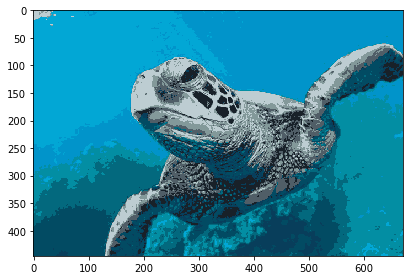

In [207]:
experiment_with_compression("turtle.jpg")

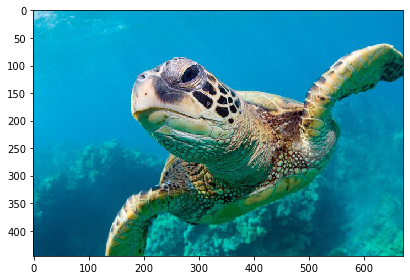

In [33]:
io.imshow("turtle.jpg")

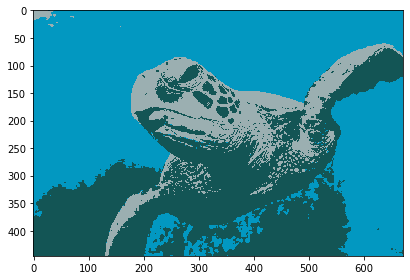

In [208]:
compress_with_kmeans("turtle.jpg", 3)

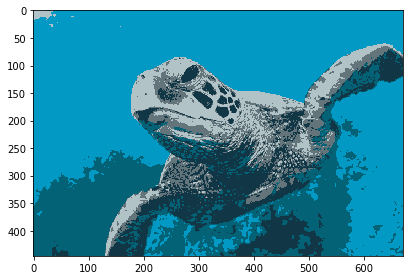

In [209]:
compress_with_kmeans("turtle.jpg", 5)

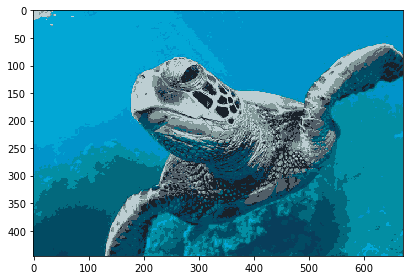

In [261]:
compress_with_kmeans("turtle.jpg", 10)

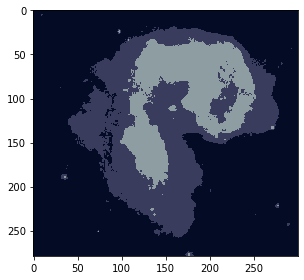

In [210]:
compress_with_kmeans("galaxy_collision.jpg",3)

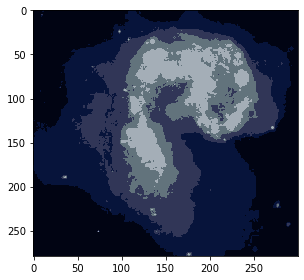

In [211]:
compress_with_kmeans("galaxy_collision.jpg",5)

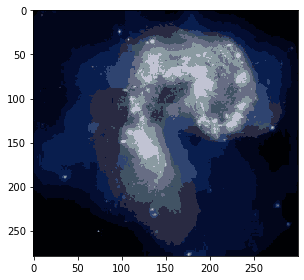

In [212]:
compress_with_kmeans("galaxy_collision.jpg",10)

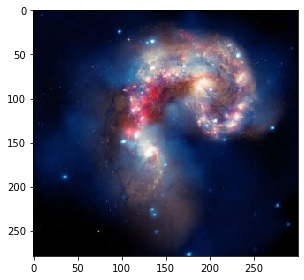

In [34]:
io.imshow("galaxy_collision.jpg")

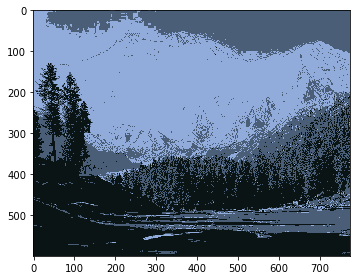

In [213]:
compress_with_kmeans("mountains.jpg",3)

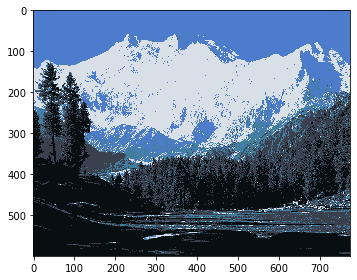

In [215]:
compress_with_kmeans("mountains.jpg",5)

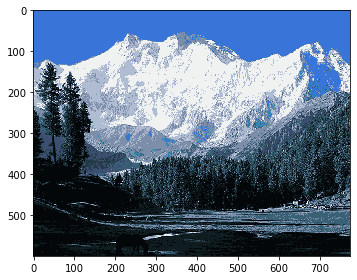

In [216]:
compress_with_kmeans("mountains.jpg",10)

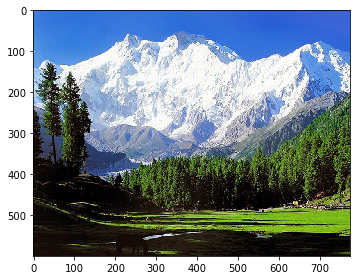

In [35]:
io.imshow("mountains.jpg")

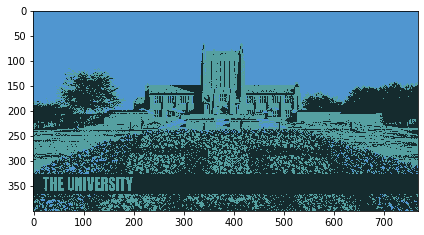

In [251]:
compress_with_kmeans("TU.jpg",3)

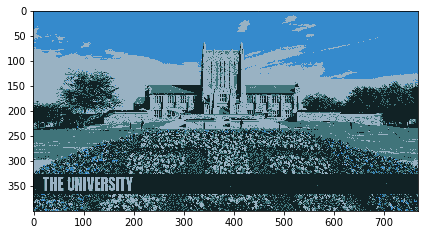

In [252]:
compress_with_kmeans("TU.jpg",5)

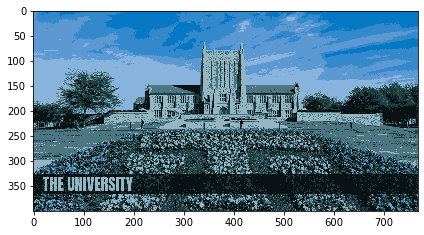

In [253]:
compress_with_kmeans("TU.jpg",10)

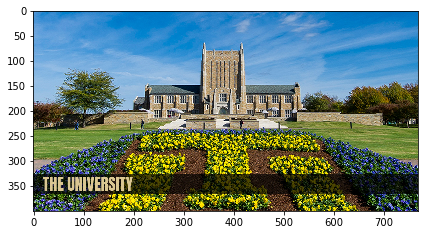

In [36]:
io.imshow("TU.jpg")

In [161]:
def compress_with_kmeans(image_path, k):
    image = io.imread(image_path)
    rows = image.shape[0]
    cols = image.shape[1]
    res_im = np.reshape(image, (rows*cols, 3))
    clf = kmeans(res_im, k, rows*cols, dimension=3)
    pixel_centroids = clf.calculate_means()
    pixel_assignments = get_assignments(pixel_centroids, res_im, k, distance_between_points)
    for idx, mean_val in enumerate(pixel_centroids):
        for c_idc, data_index in enumerate(pixel_assignments[idx]):
            res_im[data_index] = mean_val   
    res_im = np.reshape(res_im, (rows, cols, 3))
    io.imshow(res_im)

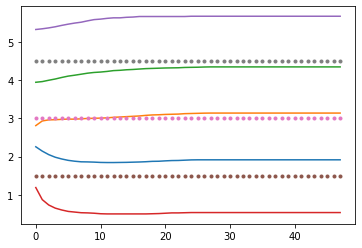

In [248]:
x = np.arange(len(running_means))
plt.plot(x, rm)
plt.plot(x, nominal,".")

In [258]:
x = np.arange(len(running_std_dev))

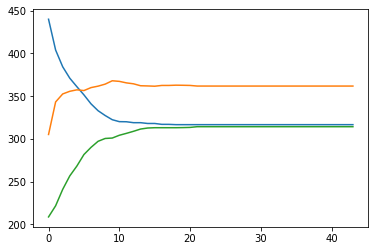

In [260]:
plt.plot(x, np.squeeze(np.array(running_std_dev)))

In [24]:
class kmeans:
    def __init__(self, data, k, N, n_iterations = 1000, convergence = 20, dimension = 1, distance_func = simple_distance):
        self.data = data
        self.k = k
        self.N = N
        self.n_iterations = n_iterations
        self.convergence = convergence
        self.means = [[] for i in range(0,k)]
        self.previous_means = [[] for i in range(0,k)]
        self.std_dev = [0 for i in range(0,k)]
        self.no_changes = 0
        self.mean_list = []
        self.dimension = dimension
        self.distance_func = distance_func
    
    def initialize_means(self):
        if self.dimension>1:
            random_idx = np.random.randint(len(self.data), size = self.k)
            self.means = self.data[random_idx,:]
        else: 
            self.means = random.sample(sorted(self.data) ,self.k)
    
    def find_optimal_cluster(self, point):
        #calculate distance between each cluster and each mean
        distances = [self.distance_func(m, point) for m in self.means]
        return distances.index(min(distances))    
    
    def is_convergence(self):
        if np.array_equal(self.means, self.previous_means):
            self.no_changes += 1
            if self.no_changes >= self.convergence:
                return True
        else:
            self.previous_means = np.copy(self.means)
        return False
    
    def calculate_means(self):
        self.initialize_means()
        #print(self.means)
        self.previous_means = np.copy(self.means)
        for i in range(0, self.n_iterations):
            clusters = self.assign_points()
            self.means = self.update_means(clusters)
            if self.is_convergence():
                break        
        means = sorted(self.means)
        return means
   
    def calculate_means_averaged(self, n_runs=50):
        means_list = []
        for i in range(0, n_runs):
            means = self.calculate_means()
            means_list.append(means)
        
        return np.mean(means_list, axis=0)
    

    def calculate_means_averaged_d(self, n_runs = 50):
        for i in range(0, n_runs):
            self.initialize_means()
            #print(self.means)
            self.previous_means = np.copy(self.means)
            for i in range(0, self.n_iterations):
                clusters = self.assign_points()
                self.means = self.update_means(clusters)
                if self.is_convergence():
                    break
            self.mean_list.append(means)
        return np.mean(self.mean_list, axis=0)
    
    def update_means(self, clusters):
        m = np.zeros((self.k, self.dimension))
        for idx, mean in enumerate(self.means):
            m[idx] = np.mean(clusters[idx], axis=0)
        return m
    
    def plot_one_convergence(self):
        self.initialize_means()
        mean_list_plotting = []
        s_dev_plotting = []
        for i in range(0, self.n_iterations):
            clusters = self.assign_points()
            means = self.update_means(clusters)
            s_dev = calculate_std_dev(means, self.data, self.k, self.N, self.distance_func)
            s_dev_plotting.append(s_dev)
            self.mean_list.append(means)
            
            mean_list_plotting.append(np.copy(means))
            self.means = means
            if(self.is_convergence()):
                break
        return mean_list_plotting, s_dev_plotting
    
    def assign_points(self):
        clusters = [[] for i in range(0,self.k)]
        for idx, data_point in enumerate(self.data):
            optimal_cluster = self.find_optimal_cluster(data_point)
            clusters[optimal_cluster].append(data_point)
        return clusters

In [6]:
def calculate_std_dev(means, data, k, N, distance_calculation):
    assignments = get_assignments(means, data, k, distance_calculation)
    std_dev = []
    for idx, cluster in enumerate(assignments):
        s = 0
        for idx_c, data_point in enumerate(cluster):
            s += distance_calculation(means[idx], data_point)
        std_dev.append(math.sqrt(s / N))
    return std_dev

In [7]:
def calculate_std_dev_euclidean(means, data, k, N, dimension):
    assignments = get_assignments(means, data, k, distance_between_points)
    std_dev = []
    for idx, cluster in enumerate(assignments):
        s = 0
        for idx_c, data_point in enumerate(cluster):
            if dimension == 1:
                s += math.sqrt((means[idx] - data_point) * (means[idx] - data_point))
            else:
                x = 0
                for i in range(0, dimension):
                    x += (means[idx][i] - data_point[i])*(means[idx][i] - data_point[i])
                s+= math.sqrt(x)
        std_dev.append(math.sqrt(s / N))
    return std_dev

In [8]:
def distance_between_points_img(a, b):
    try:
        dim = len(b)
        dim = len(a)
    except TypeError:
        return (a-b) * (a-b)
    s = 0
    for i in range(0, dim):
        s+=(int(a[i]) - int(b[i])) * (int(a[i]) - int(b[i]))
    return s

In [9]:
def distance_between_points(a, b):
    try:
        dim = len(b)
        dim = len(a)
    except TypeError:
        return (a-b) * (a-b)
    s = 0
    for i in range(0, dim):
        s+=(a[i] - b[i]) * (a[i] - b[i])
    return s

In [10]:
def simple_distance(a,b):
    return (a-b)*(a-b)

In [149]:
for idx, mean_val in enumerate(means):
    for c_idc, data_index in enumerate(assign[idx]):
        new_image_3[data_index] = mean_val    

In [12]:
def read_data(exp_num):
    data_frame = pd.read_csv(f"experiments/Experiment{exp_num}.txt")
    nom_assignments = data_frame['m']
    new_df = data_frame.drop(['m'],axis=1)
    gaus_data = new_df.to_numpy()
    N,d = gaus_data.shape
    return gaus_data, N, d, nom_assignments.to_numpy()

In [30]:
def likelihood_of_pairs(mean_assignments, nominal_assignments):
    #group nominal assignments
    likelihoods = []
    for cluster, data_idx in enumerate(mean_assignments):
        same_source = 0
        total_in_cluster = 0
        #Split data_idx into two sublists and stack them
        try:
            sublists = np.split(np.array(data_idx), 2)
        except ValueError:
            data_idx.pop()
            sublists = np.split(np.array(data_idx),2)
         #stacking!
        stacked_list = np.stack(sublists, axis=1)
        #now compare the two nominal assignments
        for pair in stacked_list:
            #print(f"pair {pair}, {assign[pair[0]]} == {assign[pair[1]]}")
            if nominal_assignments[pair[0]] == nominal_assignments[pair[1]]:
                same_source += 1
            total_in_cluster += 1
        #print(f"Cluster {cluster} | same sources {same_source} / {total_in_cluster}")
        if total_in_cluster == 0:
            likelihoods.append(0)
        else:
            likelihoods.append(same_source/total_in_cluster)
    return np.mean(likelihoods)
    

In [32]:
#Experiment 1 Part 1
#S = 3, spacing = 0.5, 1, 1.5, 2, vary k over 2, 3, 6, 8
S = 3
#Exp
spacing = [0.5, 1, 1.5, 2]
k_values = [2, 3, 6, 8]
r_exp1 = []
std_dev_exp1 = []
avg_std_dev_exp1 = []
lop_exp_1 = []
for idx, sp in enumerate(spacing):
    for k in k_values:
        experiment_data, num_of_points, dimension, nominal_assignments = read_data(idx + 1)
        classifier = kmeans(experiment_data, k, num_of_points)
        results = classifier.calculate_means_averaged(n_runs = 50)
        print(f"Results from Experiment {idx} | S = {S} | spacing = {sp} | k = {k}")
        print(f"Nominal Means {np.unique(nominal_assignments)}")
        print(f"KMeans Results {results}")
        r_exp1.append(results)
        s_d = calculate_std_dev_euclidean(results, experiment_data, k, num_of_points,dimension)
        std_dev_exp1.append(s_d)
        mean_assignments = get_assignments(results, experiment_data, k, simple_distance)
        #print(mean_assignments)
        lop = likelihood_of_pairs(mean_assignments, nominal_assignments)
        print(f"Standard Deviations {s_d}")
        print(f"Mean Standard Deviation across {k} clusters: {np.mean(s_d)}")
        print(f"Likelihood of pairs {lop}")
        lop_exp_1.append(lop)
        print()
        avg_std_dev_exp1.append(np.mean(s_d))

Results from Experiment 0 | S = 3 | spacing = 0.5 | k = 2
Nominal Means [0.5 1.  1.5]
KMeans Results [[0.0852209 ]
 [1.80701389]]
Standard Deviations [16.20411573952564, 15.3624999683936]
Mean Standard Deviation across 2 clusters: 15.78330785395962
Likelihood of pairs 0.32204149590163933

Results from Experiment 0 | S = 3 | spacing = 0.5 | k = 3
Nominal Means [0.5 1.  1.5]
KMeans Results [[-0.35184697]
 [ 0.94146696]
 [ 2.2633666 ]]
Standard Deviations [12.26130613895827, 14.623616661670676, 11.592788041931861]
Mean Standard Deviation across 3 clusters: 12.825903614186936
Likelihood of pairs 0.400013015070839

Results from Experiment 0 | S = 3 | spacing = 0.5 | k = 6
Nominal Means [0.5 1.  1.5]
KMeans Results [[-0.98480605]
 [-0.09700984]
 [ 0.6455871 ]
 [ 1.3080841 ]
 [ 2.05993085]
 [ 3.08705534]]
Standard Deviations [6.850743997602903, 10.098767793079412, 10.897004390313173, 10.415675309486188, 9.483318633701879, 5.701296052623191]
Mean Standard Deviation across 6 clusters: 8.9078010

In [26]:
#Experiment 1 Part 2
S = [5, 10]
spacing  = [0.5, 1, 1.5, 2]
results_exp_5_12= []
std_dev_exp_5_12 = []
exp_num = 0
#Go through files 
exp_num = 4
lop_exp_1_2 = []
avg_std_dev_exp_1_2 = []
for k in S:
    for idx, sp in enumerate(spacing):
        exp_num+=1
        experiment_data, num_of_points, dimension, nominal_assignments = read_data(exp_num)
        classifier = kmeans(experiment_data, k, num_of_points)
        results = classifier.calculate_means_averaged(n_runs = 50)
        print(f"Results from Experiment {exp_num} | S = {k} | spacing = {sp} | k = {k}")
        print(f"Nominal Means {np.unique(nominal_assignments)}")
        print(f"KMeans Results {results}")
        results_exp_5_12.append(results)
        s_d = calculate_std_dev_euclidean(results, experiment_data, k, num_of_points,dimension)
        std_dev_exp_5_12.append(s_d)
        print(f"Standard Deviations {s_d}")        
        mean_assignments = get_assignments(results, experiment_data, k, simple_distance)
        #print(mean_assignments)
        lop = likelihood_of_pairs(mean_assignments, nominal_assignments)
        print(f"Standard Deviations {s_d}")
        print(f"Mean Standard Deviation across {k} clusters: {np.mean(s_d)}")
        print(f"Likelihood of pairs {lop}")
        lop_exp_1_2.append(lop)
        print()
        avg_std_dev_exp_1_2.append(np.mean(s_d))
        

Results from Experiment 5 | S = 5 | spacing = 0.5 | k = 5
Nominal Means [0.5 1.  1.5 2.  2.5]
KMeans Results [[-0.63022636]
 [ 0.47187487]
 [ 1.38289559]
 [ 2.29079612]
 [ 3.36176646]]
Standard Deviations [6.994123403492697, 10.061945017115226, 12.32499294332105, 11.285769436131757, 8.280705056283612]
Standard Deviations [6.994123403492697, 10.061945017115226, 12.32499294332105, 11.285769436131757, 8.280705056283612]
Mean Standard Deviation across 5 clusters: 9.78950717126887
Likelihood of pairs 0.2689226240658075

Results from Experiment 6 | S = 5 | spacing = 1 | k = 5
Nominal Means [1. 2. 3. 4. 5.]
KMeans Results [[0.31532574]
 [1.76693419]
 [3.14442712]
 [4.47495291]
 [6.01462248]]
Standard Deviations [8.424398200917341, 10.527418363420727, 11.84095783887913, 11.244051166359503, 6.93062529627169]
Standard Deviations [8.424398200917341, 10.527418363420727, 11.84095783887913, 11.244051166359503, 6.93062529627169]
Mean Standard Deviation across 5 clusters: 9.793490173169678
Likelihood 

In [27]:
#Experiment 2
stand_dev = [1,2,3]
exp_num = 0
k = 5
num_of_points = 1000
results_exp2 = []
std_dev_exp2 = []
lop_exp_2 = []
avg_std_dev_exp_2 = []
for idx, v in enumerate(stand_dev):
    exp_num+=1
    exp_path = f"_2_{exp_num}"
    experiment_data, num_of_points, dimension, nominal_assignments = read_data(exp_path)
    classifier = kmeans(experiment_data, 5, 1000)
    results = classifier.calculate_means_averaged(n_runs = 50)
    print(f"Results from Experiment {exp_path} | S = {5} | spacing = {3} | k = {5}")
    print(f"Nominal Means {np.unique(nominal_assignments)}")
    print(f"KMeans Results {results}")
    results_exp2.append(results)
    s_d = calculate_std_dev_euclidean(results, experiment_data, k, num_of_points,dimension)
    std_dev_exp2.append(s_d)
    print(f"Standard Deviations {s_d}")        
    mean_assignments = get_assignments(results, experiment_data, k, simple_distance)
    #print(mean_assignments)
    lop = likelihood_of_pairs(mean_assignments, nominal_assignments)
    print(f"Standard Deviations {s_d}")
    print(f"Mean Standard Deviation across {k} clusters: {np.mean(s_d)}")
    print(f"Likelihood of pairs {lop}")
    lop_exp_2.append(lop)
    print()
    avg_std_dev_exp_2.append(np.mean(s_d))



Results from Experiment _2_1 | S = 5 | spacing = 3 | k = 5
Nominal Means [ 1.  4.  7. 10. 13.]
KMeans Results [[ 0.96384672]
 [ 3.8728162 ]
 [ 7.04527037]
 [10.11968094]
 [13.19412548]]
Standard Deviations [9.937253832737197, 10.232726475757946, 9.9505340061296, 9.97652177286103, 9.514919786048354]
Standard Deviations [9.937253832737197, 10.232726475757946, 9.9505340061296, 9.97652177286103, 9.514919786048354]
Mean Standard Deviation across 5 clusters: 9.922391174706826
Likelihood of pairs 0.8270350099283883

Results from Experiment _2_2 | S = 5 | spacing = 3 | k = 5
Nominal Means [ 1.  4.  7. 10. 13.]
KMeans Results [[ 0.32070737]
 [ 3.82429915]
 [ 7.30720295]
 [10.61740592]
 [13.99510895]]
Standard Deviations [9.7378840774648, 10.129003972587427, 10.109406599165947, 10.662974393414597, 8.896560428536974]
Standard Deviations [9.7378840774648, 10.129003972587427, 10.109406599165947, 10.662974393414597, 8.896560428536974]
Mean Standard Deviation across 5 clusters: 9.907165894233948
Like

In [28]:
#Experiment 3
k = 5
N = 1000
experiment_data, num_of_points, dimension, nominal_assignments = read_data("_3_1")
classifier = kmeans(experiment_data, k, num_of_points)
results_exp_3 = classifier.calculate_means_averaged(n_runs=50)
print(f"Results from Experiment _3_1 | S = {5} | spacing = {1.25} k = {5}")
print(f"Nominal Means {np.unique(nominal_assignments)}")
print(f"KMeans Results {results_exp_3}")
s_d_3 = calculate_std_dev_euclidean(results_exp_3, experiment_data, k, num_of_points,dimension)
#std_dev_exp2.append(s_d)
print(f"Standard Deviations {s_d_3}")        
mean_assignments = get_assignments(results_exp_3, experiment_data, k, simple_distance)
#print(mean_assignments)
lop = likelihood_of_pairs(mean_assignments, nominal_assignments)
print(f"Mean Standard Deviation across {k} clusters: {np.mean(s_d_3)}")
print(f"Likelihood of pairs {lop}")
print()


Results from Experiment _3_1 | S = 5 | spacing = 1.25 k = 5
Nominal Means [1.   2.25 3.5  4.75 6.  ]
KMeans Results [[-0.67157319]
 [ 1.54508561]
 [ 3.46312693]
 [ 5.15057939]
 [ 6.7252381 ]]
Standard Deviations [7.317093571291758, 10.878544042300316, 11.035045005222605, 10.624274853466273, 9.457367951570475]
Mean Standard Deviation across 5 clusters: 9.862465084770285
Likelihood of pairs 0.360771834672985



In [29]:
#expirement 4
k = 5
num_of_points = [100, 1000, 5000]
results_exp_4 = []
std_exp_4 = []
lop_exp_4 = []
std_avg_exp_4 = []
for idx, v in enumerate(num_of_points):
    exp_path = f"_4_{v}"
    experiment_data, num_of_points, dimension, nominal_assignments = read_data(exp_path)
    classifier = kmeans(experiment_data, k, v)
    results = classifier.calculate_means_averaged(n_runs=50)
    results_exp_4.append(results)
    print(f"Results from Experiment {exp_path} | S = {5} | num of points {v}")
    print(f"Nominal Means {np.unique(nominal_assignments)}")
    print(f"KMeans Results {results}")
    s_d = calculate_std_dev_euclidean(results, experiment_data, k, num_of_points,dimension)
    std_exp_4.append(s_d)
    print(f"Standard Deviations {s_d}")        
    mean_assignments = get_assignments(results, experiment_data, k, simple_distance)
    #print(mean_assignments)
    lop = likelihood_of_pairs(mean_assignments, nominal_assignments)
    print(f"Mean Standard Deviation across {k} clusters: {np.mean(s_d)}")
    print(f"Likelihood of pairs {lop}")
    lop_exp_4.append(lop)
    print()
    std_avg_exp_4.append(np.mean(s_d))

Results from Experiment _4_100 | S = 5 | num of points 100
Nominal Means [1.   2.25 3.5  4.75 6.  ]
KMeans Results [[0.41850823]
 [2.14312873]
 [3.68758699]
 [5.01144669]
 [6.2853734 ]]
Standard Deviations [2.99647352758624, 3.049583902443187, 3.1663238513716117, 3.0079602936525096, 2.9464362409928824]
Mean Standard Deviation across 5 clusters: 3.033355563209286
Likelihood of pairs 0.4921717171717172

Results from Experiment _4_1000 | S = 5 | num of points 1000
Nominal Means [1.   2.25 3.5  4.75 6.  ]
KMeans Results [[0.58860348]
 [2.04073229]
 [3.45760336]
 [4.99985979]
 [6.40113801]]
Standard Deviations [9.029054404743334, 9.745536770871217, 10.882016983262128, 11.050793298632108, 8.8851347876243]
Mean Standard Deviation across 5 clusters: 9.918507249026618
Likelihood of pairs 0.556751645544749

Results from Experiment _4_5000 | S = 5 | num of points 5000
Nominal Means [1.   2.25 3.5  4.75 6.  ]
KMeans Results [[0.71253636]
 [2.15588911]
 [3.54351722]
 [4.92780334]
 [6.32638994]]
Sta